In [ ]:
MODEL_NAME = "llama3.1:8b"
API_URL = "http://localhost:11434/v1/chat/completions"
N_SELF_CONSISTENCY = 1
QUESTIONS_NUM_IN_SAMPLE = 50
BASELINE_TEMPERATURE = 0.0
SELF_CONSISTENCY_TEMPERATURE = 0.7

# N_SELF_CONSISTENCY = none (without), QUESTIONS_NUM_IN_SAMPLE = 50 --> time = 79 minutes

In [149]:
import pandas as pd

df = pd.read_csv("../data/external/train.csv")
df = df.reset_index(drop=True)

import numpy as np
SEED = 16
np.random.seed(SEED)
sample_df = df.sample(n=QUESTIONS_NUM_IN_SAMPLE, random_state=SEED)
sample_df

,id,prompt,A,B,C,D,E,answer
154,154,What are the two main factors that cause resis...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,B
0,0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
174,174,What is the difference between illuminance and...,Illuminance is the amount of light absorbed by...,Illuminance is the amount of light falling on ...,Illuminance is the amount of light concentrate...,Illuminance is the amount of light emitted by ...,Illuminance is the amount of light reflected b...,B
59,59,What are the Navier-Stokes equations?,The Navier-Stokes equations are partial differ...,The Navier-Stokes equations are partial differ...,The Navier-Stokes equations are partial differ...,The Navier-Stokes equations are algebraic equa...,The Navier-Stokes equations are algebraic equa...,A
112,112,What is the required excess quark per billion ...,One,Five,Three,Two,Four,A
170,170,What can be inferred about the electronic entr...,Insulators and metals have zero density of sta...,Insulators have zero density of states at the ...,Insulators have non-zero density of states at ...,Insulators and metals have varying densities o...,Insulators and metals have non-zero density of...,B
73,73,"What is the estimated redshift of CEERS-93316,...","Approximately z = 6.0, corresponding to 1 bill...","Approximately z = 16.7, corresponding to 235.8...","Approximately z = 3.0, corresponding to 5 bill...","Approximately z = 10.0, corresponding to 13 bi...","Approximately z = 13.0, corresponding to 30 bi...",B
7,7,Which of the following statements accurately d...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,D
29,29,What is the function of the fibrous cardiac sk...,The fibrous cardiac skeleton is a system of bl...,The fibrous cardiac skeleton is responsible fo...,The fibrous cardiac skeleton provides structur...,The fibrous cardiac skeleton is a network of n...,The fibrous cardiac skeleton is a protective l...,C
32,32,What is the second law of thermodynamics?,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,E


In [150]:
import requests

OLLAMA_API_URL = "http://localhost:11434/api/chat"

def query_ollama(payload):
    response = requests.post(OLLAMA_API_URL, json=payload)
    response.raise_for_status()
    return response.json()


def prompt(
    question: str,
    model: str = "llama3.1:8b",
    temperature: float = 0.0,
):
    response = query_ollama({
        "model": model,
        "messages": [
            {"role": "user", "content": question}
        ],
        "options": {
            "temperature": temperature
        },
        "stream": False
    })

    return response["message"]["content"]


In [151]:
import re
from collections import Counter
def normalize_letter(text: str) -> str | None:
    if not isinstance(text, str):
        return None
    t = text.strip().upper()
    # Szukaj wzorca litery A-E (np. "C", "C)", "Answer: C", "Option C")
    m = re.search(r'\b([A-E])\b', t)
    if m:
        return m.group(1)
    m2 = re.search(r'\bOPTION\s+([A-E])\b', t)
    if m2:
        return m2.group(1)
    # Fallback: pierwszy znak jeśli to A-E
    return t[:1] if t[:1] in list("ABCDE") else None

In [152]:
import ast
import re

def get_question_text(row):
    for key in ['Question', 'question', 'prompt', 'Stem', 'text']:
        if key in row and isinstance(row[key], str) and row[key].strip():
            return row[key]
    raise KeyError("Nie znaleziono kolumny z pytaniem (np. 'question'/'Question'/'prompt').")

def get_choices(row):
    # 1) kolumna 'choices' jako lista/JSON
    if 'choices' in row and row['choices'] is not None:
        val = row['choices']
        try:
            seq = ast.literal_eval(val) if isinstance(val, str) else val
        except Exception:
            seq = None
        if isinstance(seq, (list, tuple)) and len(seq) > 0:
            return {chr(ord('A') + i): str(c) for i, c in enumerate(seq)}
    # 2) standardowe kolumny A/B/C/D/E
    labels = [c for c in ['A','B','C','D','E'] if c in row and isinstance(row[c], str) and row[c].strip()]
    if labels:
        return {lab: row[lab] for lab in labels}
    # 3) kolumny typu option_A, option_B, ...
    opts = {}
    for col in row.index:
        m = re.match(r'option_([A-E])', col, re.I)
        if m and isinstance(row[col], str) and row[col].strip():
            opts[m.group(1).upper()] = row[col]
    if opts:
        return dict(sorted(opts.items()))
    raise KeyError("Nie znaleziono kolumn z opcjami (np. 'A','B',...'choices','option_A').")

def build_mc_prompt_row(row):
    q = get_question_text(row)
    choices = get_choices(row)
    options_text = "\n".join([f"{k}) {v}" for k, v in choices.items()])
    letters = "/".join(choices.keys())
    return f"""You are an expert science examiner.
Select the single best option and answer ONLY with the letter ({letters}).

Question:
{q}

Options:
{options_text}

Answer ({letters}):"""

def add_baseline_answers(df, model=MODEL_NAME, temperature=BASELINE_TEMPERATURE):
    answers = []
    for _, row in df.iterrows():
        prompt_text = build_mc_prompt_row(row)
        raw = prompt(prompt_text, model=model, temperature=temperature)
        L = normalize_letter(raw)
        answers.append(L)
    df['baseline_answer'] = answers
    return df

In [153]:
sample_df = add_baseline_answers(sample_df)

In [154]:
sample_df

,id,prompt,A,B,C,D,E,answer,baseline_answer
154,154,What are the two main factors that cause resis...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,B,C
0,0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,E
174,174,What is the difference between illuminance and...,Illuminance is the amount of light absorbed by...,Illuminance is the amount of light falling on ...,Illuminance is the amount of light concentrate...,Illuminance is the amount of light emitted by ...,Illuminance is the amount of light reflected b...,B,A
59,59,What are the Navier-Stokes equations?,The Navier-Stokes equations are partial differ...,The Navier-Stokes equations are partial differ...,The Navier-Stokes equations are partial differ...,The Navier-Stokes equations are algebraic equa...,The Navier-Stokes equations are algebraic equa...,A,A
112,112,What is the required excess quark per billion ...,One,Five,Three,Two,Four,A,A
170,170,What can be inferred about the electronic entr...,Insulators and metals have zero density of sta...,Insulators have zero density of states at the ...,Insulators have non-zero density of states at ...,Insulators and metals have varying densities o...,Insulators and metals have non-zero density of...,B,B
73,73,"What is the estimated redshift of CEERS-93316,...","Approximately z = 6.0, corresponding to 1 bill...","Approximately z = 16.7, corresponding to 235.8...","Approximately z = 3.0, corresponding to 5 bill...","Approximately z = 10.0, corresponding to 13 bi...","Approximately z = 13.0, corresponding to 30 bi...",B,A
7,7,Which of the following statements accurately d...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,D,B
29,29,What is the function of the fibrous cardiac sk...,The fibrous cardiac skeleton is a system of bl...,The fibrous cardiac skeleton is responsible fo...,The fibrous cardiac skeleton provides structur...,The fibrous cardiac skeleton is a network of n...,The fibrous cardiac skeleton is a protective l...,C,C
32,32,What is the second law of thermodynamics?,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,E,E


In [ ]:
import re

def build_cot_visible_prompt_row(row):
    mc_text = build_mc_prompt_row(row)
    letters = "/".join(get_choices(row).keys())

    return (
        mc_text
        + "\n\n"
        + "Instruction: Think step-by-step and explain your reasoning.\n"
        + "On the VERY LAST line output exactly: FINAL: X\n"
        + f"Where X is one of ({letters}). Do not add anything after that."
    )

def extract_final_letter(raw_text: str) -> str | None:
    if not isinstance(raw_text, str):
        return None
    t = raw_text.strip().upper()
    m = re.search(r"FINAL:\s*([A-E])\b", t)
    if m:
        return m.group(1)
    return normalize_letter(raw_text)

In [ ]:
def add_cot_visible_answers(df, model=MODEL_NAME, temperature=BASELINE_TEMPERATURE):
    raw_list = [] # pełna odpowiedź z rozumowaniem
    ans_list = [] # sama litera odpowiedzi

    for _, row in df.iterrows():
        prompt_text = build_cot_visible_prompt_row(row)
        raw = prompt(prompt_text, model=model, temperature=temperature)
        L = extract_final_letter(raw)

        raw_list.append(raw)
        ans_list.append(L)

    df["cot_visible_raw"] = raw_list
    df["cot_visible_answer"] = ans_list
    return df

In [ ]:
from collections import Counter

def add_cot_visible_consistency_majority(df, model=MODEL_NAME, n=N_SELF_CONSISTENCY, temperature=SELF_CONSISTENCY_TEMPERATURE):
    samples_raw = [] # lista n surowych odpowiedzi
    samples_letters = [] # lista n liter
    majority_answers = [] # wynik majority

    for _, row in df.iterrows():
        prompt_text = build_cot_visible_prompt_row(row)

        raws = []
        letters = []

        for _ in range(int(n)):
            raw = prompt(prompt_text, model=model, temperature=temperature)
            L = extract_final_letter(raw)
            raws.append(raw)
            if L:
                letters.append(L)

        # majority vote
        if letters:
            cnt = Counter(letters)
            top = max(cnt.values())
            winners = sorted([k for k, v in cnt.items() if v == top])
            maj = winners[0]
        else:
            maj = None

        samples_raw.append(raws)
        samples_letters.append(letters)
        majority_answers.append(maj)

    df["cot_visible_samples_raw"] = samples_raw
    df["cot_visible_samples_letters"] = samples_letters
    df["cot_visible_consistency_answer"] = majority_answers
    return df

In [ ]:
def build_cot_hidden_prompt_row(row):
    mc_text = build_mc_prompt_row(row)
    letters = "/".join(get_choices(row).keys())

    return (
        mc_text
        + "\n\n"
        + "Instruction: Think step-by-step privately, but DO NOT reveal your reasoning.\n"
        + f"Return ONLY the final letter ({letters}). No explanation, no extra words, no punctuation."
    )

def add_cot_hidden_answers(df, model=MODEL_NAME, temperature=BASELINE_TEMPERATURE):

    # jeśli już policzone, nie licz drugi raz (np. przy ponownym uruchomieniu komórek)
    if "cot_hidden_answer" in df.columns:
        return df

    answers = []
    for _, row in df.iterrows():
        prompt_text = build_cot_hidden_prompt_row(row)
        raw = prompt(prompt_text, model=model, temperature=temperature)
        L = normalize_letter(raw)
        answers.append(L)

    df["cot_hidden_answer"] = answers
    return df

def add_cot_hidden_consistency_majority(df, model=MODEL_NAME, n=N_SELF_CONSISTENCY, temperature=SELF_CONSISTENCY_TEMPERATURE):

    if "cot_hidden_consistency_answer" in df.columns:
        return df

    samples_letters = [] # lista liter z n pró
    majority_answers = [] # majority vote

    for _, row in df.iterrows():
        prompt_text = build_cot_hidden_prompt_row(row)

        letters = []
        for _ in range(int(n)):
            raw = prompt(prompt_text, model=model, temperature=temperature)
            L = normalize_letter(raw)
            if L:
                letters.append(L)

        if letters:
            cnt = Counter(letters)
            top = max(cnt.values())
            winners = sorted([k for k, v in cnt.items() if v == top])
            maj = winners[0]
        else:
            maj = None

        samples_letters.append(letters)
        majority_answers.append(maj)

    df["cot_hidden_samples_letters"] = samples_letters
    df["cot_hidden_consistency_answer"] = majority_answers
    return df

In [ ]:
def accuracy(y_true, y_pred):
    pairs = [(a, b) for a, b in zip(y_true, y_pred) if b is not None]
    if not pairs:
        return 0.0
    return sum(1 for a, b in pairs if a == b) / len(pairs)

def beneficial_detrimental(y_true, base, new):
    idx = [i for i in range(len(y_true)) if base[i] is not None and new[i] is not None]
    changed = sum(1 for i in idx if base[i] != new[i])
    beneficial = sum(1 for i in idx if base[i] != y_true[i] and new[i] == y_true[i])
    detrimental = sum(1 for i in idx if base[i] == y_true[i] and new[i] != y_true[i])
    return changed, beneficial, detrimental, len(idx)

def summarize_mc_experiment(df):
    y_true = [str(x).strip().upper() for x in df["answer"].tolist()]

    base = df["baseline_answer"].tolist()

    methods = [("CoT-visible", "cot_visible_answer")]

    if "cot_visible_consistency_answer" in df.columns:
        methods.append(("CoT-visible + consistency", "cot_visible_consistency_answer"))

    if "cot_hidden_answer" in df.columns:
        methods.append(("CoT-hidden", "cot_hidden_answer"))

    if "cot_hidden_consistency_answer" in df.columns:
        methods.append(("CoT-hidden + consistency", "cot_hidden_consistency_answer"))

    print("=== ACCURACY ===")
    print("baseline                   :", accuracy(y_true, base))
    for name, col in methods:
        preds = df[col].tolist()
        print(f"{name:<26}:", accuracy(y_true, preds))

    print("\n=== CHANGES VS BASELINE (where both preds exist) ===")
    for name, col in methods:
        preds = df[col].tolist()
        ch, ben, det, n = beneficial_detrimental(y_true, base, preds)
        print(f"{name:<26}: changed {ch}/{n}, beneficial {ben}, detrimental {det}")

    print("\n=== PREVIEW ===")
    cols = ["answer", "baseline_answer"]
    for _, col in methods:
        cols.append(col)

    cols = list(dict.fromkeys([c for c in cols if c in df.columns]))
    print(df[cols].head(min(10, len(df))))


In [ ]:
# 1) CoT-visible 
sample_df = add_cot_visible_answers(sample_df)

# 2) CoT-visible self-consistency (uwaga, bardzo wolno działa, wykomentowane celowo)
#sample_df = add_cot_visible_consistency_majority(sample_df)

# CoT-hidden (tani krok: 1 wywołanie modelu na pytanie)
sample_df = add_cot_hidden_answers(sample_df)

# CoT-hidden + self-consistency (uwaga, bardzo wolno działa, wykomentowane celowo)
#sample_df = add_cot_hidden_consistency_majority(sample_df)

# 3) Podsumowanie
summarize_mc_experiment(sample_df)

# 4) Podgląd
sample_df

=== ACCURACY ===
baseline                   : 0.64
CoT-visible               : 0.72
CoT-hidden                : 0.72

=== CHANGES VS BASELINE (where both preds exist) ===
CoT-visible               : changed 12/50, beneficial 7, detrimental 3
CoT-hidden                : changed 10/50, beneficial 6, detrimental 2

=== PREVIEW ===
    answer baseline_answer cot_visible_answer cot_hidden_answer
154      B               C                  E                 C
0        D               E                  D                 D
174      B               A                  B                 B
59       A               A                  A                 A
112      A               A                  A                 B
170      B               B                  B                 B
73       B               A                  A                 A
7        D               B                  B                 B
29       C               C                  C                 C
32       E               E    

,id,prompt,A,B,C,D,E,answer,baseline_answer,cot_visible_raw,cot_visible_answer,cot_hidden_answer
154,154,What are the two main factors that cause resis...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,B,C,"To determine the correct answer, let's analyze...",E,C
0,0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,E,"To answer this question, let's break it down s...",D,D
174,174,What is the difference between illuminance and...,Illuminance is the amount of light absorbed by...,Illuminance is the amount of light falling on ...,Illuminance is the amount of light concentrate...,Illuminance is the amount of light emitted by ...,Illuminance is the amount of light reflected b...,B,A,"To answer this question, let's break down the ...",B,B
59,59,What are the Navier-Stokes equations?,The Navier-Stokes equations are partial differ...,The Navier-Stokes equations are partial differ...,The Navier-Stokes equations are partial differ...,The Navier-Stokes equations are algebraic equa...,The Navier-Stokes equations are algebraic equa...,A,A,"To answer this question, let's break it down s...",A,A
112,112,What is the required excess quark per billion ...,One,Five,Three,Two,Four,A,A,To determine the required excess quark per bil...,A,B
170,170,What can be inferred about the electronic entr...,Insulators and metals have zero density of sta...,Insulators have zero density of states at the ...,Insulators have non-zero density of states at ...,Insulators and metals have varying densities o...,Insulators and metals have non-zero density of...,B,B,"To answer this question, let's break it down s...",B,B
73,73,"What is the estimated redshift of CEERS-93316,...","Approximately z = 6.0, corresponding to 1 bill...","Approximately z = 16.7, corresponding to 235.8...","Approximately z = 3.0, corresponding to 5 bill...","Approximately z = 10.0, corresponding to 13 bi...","Approximately z = 13.0, corresponding to 30 bi...",B,A,To determine the estimated redshift of CEERS-9...,A,A
7,7,Which of the following statements accurately d...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,D,B,"To determine the correct answer, let's break d...",B,B
29,29,What is the function of the fibrous cardiac sk...,The fibrous cardiac skeleton is a system of bl...,The fibrous cardiac skeleton is responsible fo...,The fibrous cardiac skeleton provides structur...,The fibrous cardiac skeleton is a network of n...,The fibrous cardiac skeleton is a protective l...,C,C,"To determine the correct answer, let's analyze...",C,C
32,32,What is the second law of thermodynamics?,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,E,E,"To answer this question, let's break it down s...",A,E


Accuracy [%]: {'Baseline': np.float64(64.0), 'CoT-visible': np.float64(72.0), 'CoT-hidden': np.float64(72.0)}


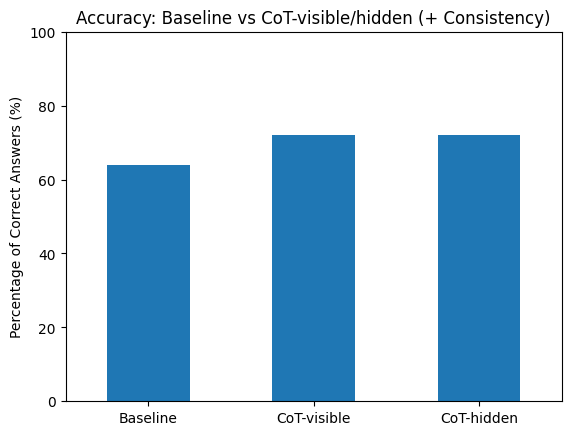

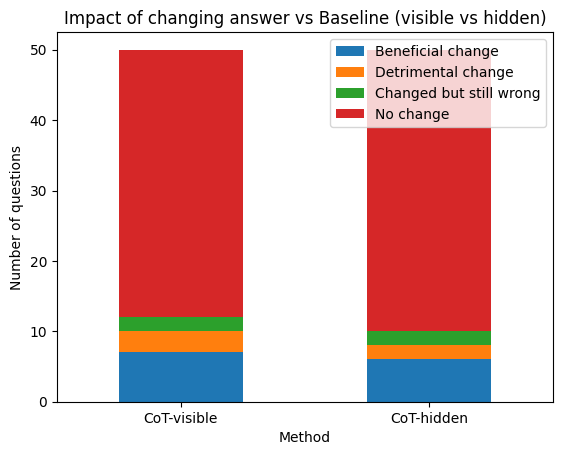

In [ ]:
# Zakomentowane zostały części wykresu dla self-cosistency

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

true = sample_df['answer'].astype(str).str.strip().str.upper()

pred_baseline = sample_df['baseline_answer'].astype(str).str.strip().str.upper()
pred_cot_vis = sample_df['cot_visible_answer'].astype(str).str.strip().str.upper()
#pred_cot_vis_cons = sample_df['cot_visible_consistency_answer'].astype(str).str.strip().str.upper()

pred_cot_hid = sample_df['cot_hidden_answer'].astype(str).str.strip().str.upper()
#pred_cot_hid_cons = sample_df['cot_hidden_consistency_answer'].astype(str).str.strip().str.upper()


# Wykres 1

acc = {
    'Baseline': (pred_baseline == true).mean() * 100,
    'CoT-visible': (pred_cot_vis == true).mean() * 100,
    #'CoT-visible + Consistency': (pred_cot_vis_cons == true).mean() * 100,
    'CoT-hidden': (pred_cot_hid == true).mean() * 100,
    #'CoT-hidden + Consistency': (pred_cot_hid_cons == true).mean() * 100,
}

print("Accuracy [%]:", acc)

pd.Series(acc).plot(kind='bar')
plt.title('Accuracy: Baseline vs CoT-visible/hidden (+ Consistency)')
plt.ylabel('Percentage of Correct Answers (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.show()


# Wykres 2

def _change_impact_counts(true_s, base_s, new_s):
    base_correct = (base_s == true_s)
    new_correct  = (new_s == true_s)
    changed      = (new_s != base_s)

    beneficial = ((~base_correct) & new_correct).sum()
    detrimental = (base_correct & (~new_correct)).sum()
    changed_neutral = (changed & (~base_correct) & (~new_correct)).sum()
    no_change = (~changed).sum()

    return {
        "Beneficial change": beneficial,
        "Detrimental change": detrimental,
        "Changed but still wrong": changed_neutral,
        "No change": no_change
    }

impact_vis = _change_impact_counts(true, pred_baseline, pred_cot_vis)
#impact_vis_cons = _change_impact_counts(true, pred_baseline, pred_cot_vis_cons)
impact_hid = _change_impact_counts(true, pred_baseline, pred_cot_hid)
#impact_hid_cons = _change_impact_counts(true, pred_baseline, pred_cot_hid_cons)

impact_df = pd.DataFrame([
    {"Method": "CoT-visible", **impact_vis},
    #{"Method": "CoT-visible + Consistency", **impact_vis_cons},
    {"Method": "CoT-hidden", **impact_hid},
    #{"Method": "CoT-hidden + Consistency", **impact_hid_cons},
]).set_index("Method")

impact_df.plot(kind="bar", stacked=True)
plt.title("Impact of changing answer vs Baseline (visible vs hidden)")
plt.xlabel("Method")
plt.ylabel("Number of questions")
plt.xticks(rotation=0)
plt.show()

# Eksperyment "Chain of thought"
Celem eksperymentu było porównanie zachowania modelu LLaMA-3.1-8B w odpowiadaniu na pytania zamknięte, gdy prompt jedynie ząda podania odpowiedzi, do zachowania gdy prompt wymaga zastanowienia się i podjęcia deliberacji - zarówno jawnie (treść przemyśleń zwracana uzytkownikowi) jak i niejawnie (następuje zastanowienie, ale jego treść nie jest publikowana i model zwraca tylko ostateczną odpowiedź).

# Przeprowadzono eksperyment porównujący zachowanie modelu dla następujących konfiguracji promptu:

1. Baseline - prompt nakazujący odpowiedź wprost na pytanie, z pozycji eksperta
"You are an expert science examiner. Select the single best option and answer ONLY with the letter"

2. CoT-visible - prompt nakazujący jawny łańcuch rozumowania, a następnie odpowiedź: treść rozumowania oraz wynik ostateczny

3. CoT-hidden - prompt nakazujący niejawny łańcuch rozumowania, a następnie odpowiedź tylko ostateczną literą, bez dzielenia się przeprowadzonym "rozumowaniem"

# Dla wariantów osiągnięto następujące rezultaty:

## Accuracy:

- baseline 64%
- CoT-visible 72%
- CoT-hidden 72% 

Świadczy to o pozytywnym wpływie samego procesu "namysłu" nad odpowiedzią, bez róznicy czy następuje ujawnienie treści rozumowania

## Zmiana względem baseline

CoT-visible:
- zmiana odpowiedzi w 12/50 przypadków (24%)
- 7 zmian korzystnych (baseline błędne --> CoT poprawne)
- 3 zmiany szkodliwe (baseline poprawne --> CoT błędne)

CoT-hidden:
- zmiana odpowiedzi w 10/50 przypadków (20%)
- 6 zmian korzystnych
- 2 zmiany szkodliwe

Świadczy to o tym, ze namysł częściej koryguje błędne pierwotne przekonania modelu, niż psuje poprawne odpowiedzi, dodatkowo niejawne rozumowanie jest bardziej konserwatywne i stabilne.

# Wnioski

1. Wymuszenie namysłu (Chain-of-Thought) znacząco poprawia jakość odpowiedzi modelu w zadaniach multiple-choice.

2. Jawność rozumowania nie jest konieczna, aby uzyskać poprawę — CoT-hidden osiąga ten sam poziom accuracy.

3. Niejawny CoT jest bardziej stabilny epistemicznie:
- mniej niepotrzebnych zmian odpowiedzi
- mniej regresji względem baseline

4. CoT-hidden jest preferowanym wariantem, szczególnie w systemach produkcyjnych lub kosztowo wrażliwych.